# Recruit Restaurant Visitor Forecasting
This notebook uses a dataset from [Kaggle's Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting) competition:
> In this competition, you're challenged to use reservation and visitation data to predict the total number of visitors to a restaurant for future dates. This information will help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers.

## Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def print_timedelta(df):
    print('Timedelta: {} days from {} to {}'.format(
        pd.Timedelta(df.max() - df.min()).days, df.min(), df.max()))

## Reservations

In [3]:
air_reserve = pd.read_csv('./input/air_reserve.csv', parse_dates=['visit_datetime', 'reserve_datetime'])

air_reserve['visit_datetime'] = air_reserve['visit_datetime'].apply(lambda x: x.date())
air_reserve['reserve_datetime'] = air_reserve['reserve_datetime'].apply(lambda x: x.date())

print('Size of the dataframe: {} rows and {} columns'.format(*air_reserve.shape))
air_reserve.head()

Size of the dataframe: 92378 rows and 4 columns


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01,2016-01-01,1
1,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,3
2,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,6
3,air_877f79706adbfb06,2016-01-01,2016-01-01,2
4,air_db80363d35f10926,2016-01-01,2016-01-01,5


In [4]:
print_timedelta(air_reserve.visit_datetime)
print_timedelta(air_reserve.reserve_datetime)

Timedelta: 516 days from 2016-01-01 to 2017-05-31
Timedelta: 477 days from 2016-01-01 to 2017-04-22


In [5]:
hpg_reserve = pd.read_csv('./input/hpg_reserve.csv', parse_dates=['visit_datetime', 'reserve_datetime'])

hpg_reserve['visit_datetime'] = hpg_reserve['visit_datetime'].apply(lambda x: x.date())
hpg_reserve['reserve_datetime'] = hpg_reserve['reserve_datetime'].apply(lambda x: x.date())

print('Size of the dataframe: {} rows and {} columns'.format(*hpg_reserve.shape))
hpg_reserve.head()

Size of the dataframe: 2000320 rows and 4 columns


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01,2016-01-01,1
1,hpg_dac72789163a3f47,2016-01-01,2016-01-01,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01,2016-01-01,2
3,hpg_24bb207e5fd49d4a,2016-01-01,2016-01-01,5
4,hpg_25291c542ebb3bc2,2016-01-01,2016-01-01,13


In [6]:
print_timedelta(hpg_reserve.visit_datetime)
print_timedelta(hpg_reserve.reserve_datetime)

Timedelta: 516 days from 2016-01-01 to 2017-05-31
Timedelta: 477 days from 2016-01-01 to 2017-04-22


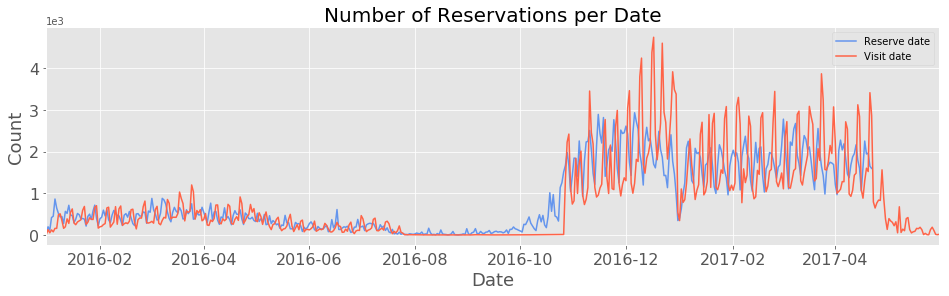

In [7]:
ax = plt.gca()

air_reserve[['reserve_datetime', 'reserve_visitors']].groupby('reserve_datetime').sum().plot(
    kind='line',
    figsize=(16,4),
    ax=ax,
    fontsize=16,
    color='cornflowerblue')

air_reserve[['visit_datetime', 'reserve_visitors']].groupby('visit_datetime').sum().plot(
    kind='line',
    figsize=(16,4),
    ax=ax,
    fontsize=16,
    color='tomato')

ax.legend(labels=['Reserve date', 'Visit date'])
plt.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Number of Reservations per Date', fontsize=20)
plt.show()

## Train set

In [8]:
train = pd.read_csv('./input/air_visit_data.csv', parse_dates=['visit_date'])
train['visit_date'] = train['visit_date'].apply(lambda x: x.date())

print('Size of the dataframe: {} rows and {} columns'.format(*train.shape))
train.head()

Size of the dataframe: 252108 rows and 3 columns


,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [9]:
print_timedelta(train.visit_date)

Timedelta: 477 days from 2016-01-01 to 2017-04-22


## Target variable

In [10]:
from scipy.stats import zscore

outliers = train.groupby('air_store_id')['visitors'].transform(zscore) > 3

print('min: {}, max: {}, mean: {:.2f}, std: {:.2f}'.format(
    min(train.visitors), max(train.visitors), train.visitors.mean(), train.visitors.std()))
print('Count of values above 3 std: {}'.format(outliers.sum()))

min: 1, max: 877, mean: 20.97, std: 16.76
Count of values above 3 std: 2026


min: 1.0, max: 181.0, mean: 20.61, std: 15.63


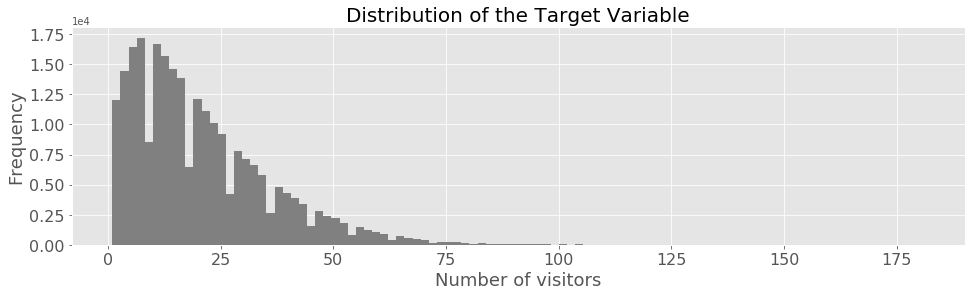

In [11]:
train[outliers] = np.nan
train.dropna(inplace=True)

print('min: {}, max: {}, mean: {:.2f}, std: {:.2f}'.format(
    min(train.visitors), max(train.visitors), train.visitors.mean(), train.visitors.std()))

train.visitors.plot(
    kind='hist',
    bins=100,
    figsize=(16,4), 
    fontsize=16,
    color='grey')

plt.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
plt.xlabel('Number of visitors', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Distribution of the Target Variable', fontsize=20)
plt.show()

## Test set

In [12]:
test = pd.read_csv('./input/sample_submission.csv')

test['visit_date'] = test['id'].map(lambda x: str(x).split('_')[2])
test['air_store_id'] = test['id'].map(lambda x: '_'.join(x.split('_')[:2]))
test['visit_date'] = pd.to_datetime(test['visit_date'])
test['visit_date'] = test['visit_date'].apply(lambda x: x.date())

print('Size of the dataframe: {} rows and {} columns'.format(*test.shape))
test.head()

Size of the dataframe: 32019 rows and 4 columns


,id,visitors,visit_date,air_store_id
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9


In [13]:
print_timedelta(test.visit_date)

Timedelta: 38 days from 2017-04-23 to 2017-05-31
